### **Chapter 10 – Introduction to Artificial Neural Networks with Keras**



**(This is from notebook DSML07_Trees.ipynb)**

Often times in Python (similar to R) the best way to sync the packages that one needs is to create a <font color='purple'>**new installation**</font>. On Mac and using Anaconda, the steps are

1) Create a **new environment** with the version of Python (3.8 is the latest at the moment) and the main packages you want, e.g.

<font color='darkpink'> conda create -n DSML_TF python=3.7 tensorflow numpy pandas scipy scikit-learn statsmodels matplotlib seaborn jupyterlab python-graphviz
 </font>

2) Then **activate** the environment DSML **before** starting your Jupyter Lab/Notebook 

<font color='darkpink'> conda activate DSML_TF </font>

or before you need to install an additional package as in this example

<font color='darkpink'> conda install -c anaconda pydot </font>  

(_or perhaps_: <font color='darkpink'>conda install -c conda-forge pydot</font> )

3) When you are done deactivate the environment - only one is active at any point, so Anacond knows what to do:

<font color='darkpink'> conda deactivate </font>

In [1]:
%load_ext autoreload
%autoreload 2

#### Setup

%load_ext autoreload
%autoreload 2
import sysFirst, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [3]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
# Tree plotting
import pydot
from IPython.display import Image
import graphviz
from io import StringIO  

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
tf.__version__

'2.0.0'

In [7]:
keras.__version__

'2.2.4-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [9]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [10]:
X_train_full[1,:,:] # 1 image

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

In [11]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [14]:
#X_train[0]

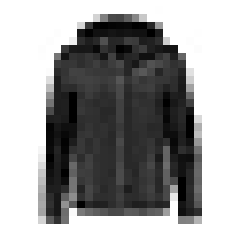

In [15]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [16]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [18]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [19]:
X_valid.shape

(5000, 28, 28)

In [20]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


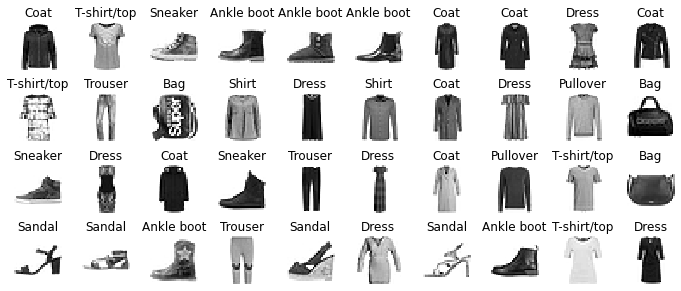

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [22]:
### Start building the model

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
### Another syntax for the same model 

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.layers

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [29]:
###  A plot of the model structure

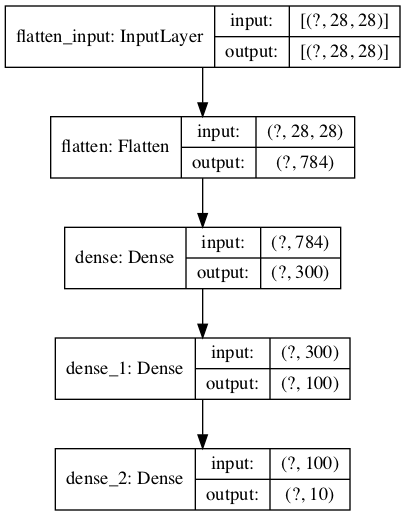

In [30]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [31]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [32]:
# some more information available in 'model'

In [33]:
model.get_layer(hidden1.name) is hidden1

True

In [34]:
weights, biases = hidden1.get_weights()

In [35]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [36]:
weights.shape

(784, 300)

In [37]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
biases.shape

(300,)

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="SGD", #  optimizer="adam"
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [40]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 8s 137us/sample - loss: 0.7228 - accuracy: 0.7622 - val_loss: 0.5310 - val_accuracy: 0.8148
Epoch 2/30
55000/55000 [==============================] - 7s 119us/sample - loss: 0.4838 - accuracy: 0.8323 - val_loss: 0.4496 - val_accuracy: 0.8450
Epoch 3/30
55000/55000 [==============================] - 7s 120us/sample - loss: 0.4379 - accuracy: 0.8473 - val_loss: 0.4178 - val_accuracy: 0.8556
Epoch 4/30
55000/55000 [==============================] - 7s 121us/sample - loss: 0.4127 - accuracy: 0.8556 - val_loss: 0.3899 - val_accuracy: 0.8654
Epoch 5/30
55000/55000 [==============================] - 7s 123us/sample - loss: 0.3929 - accuracy: 0.8625 - val_loss: 0.3971 - val_accuracy: 0.8614
Epoch 6/30
55000/55000 [==============================] - 7s 130us/sample - loss: 0.3776 - accuracy: 0.8675 - val_loss: 0.3720 - val_accuracy: 0.8740
Epoch 7/30
55000/55000 [===========================

In [41]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [42]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


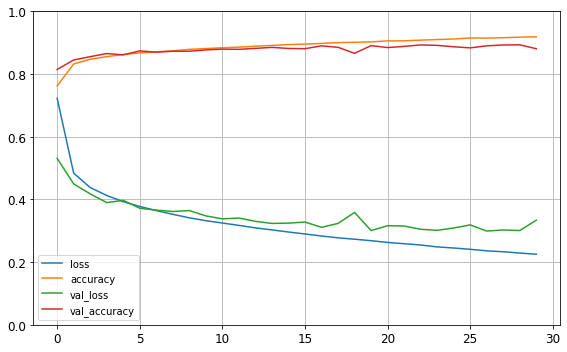

In [44]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [45]:
model.evaluate(X_test, y_test, verbose=0) # [0.33780701770782473, 0.8781]

[0.3698365963816643, 0.8657]

In [46]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [47]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [49]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


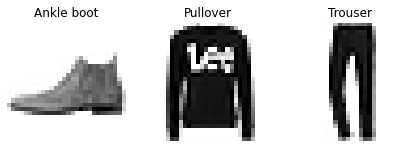

In [50]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the Boston house prices data https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

( California housing dataset (the original one, not the modified one as in chapter 2) wouldn't load for me )

In [51]:
from sklearn.datasets import fetch_california_housing, load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#housing = fetch_california_housing()
housing = load_boston()

In [52]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 284 samples, validate on 95 samples
Epoch 1/20
284/284 [==============================] - 1s 2ms/sample - loss: 490.1765 - val_loss: 505.8003
Epoch 2/20
284/284 [==============================] - 0s 224us/sample - loss: 349.4712 - val_loss: 338.0888
Epoch 3/20
284/284 [==============================] - 0s 226us/sample - loss: 211.1127 - val_loss: 198.2504
Epoch 4/20
284/284 [==============================] - 0s 317us/sample - loss: 128.0113 - val_loss: 121.6333
Epoch 5/20
284/284 [==============================] - 0s 256us/sample - loss: 85.2560 - val_loss: 83.6854
Epoch 6/20
284/284 [==============================] - 0s 193us/sample - loss: 60.2812 - val_loss: 63.0151
Epoch 7/20
284/284 [==============================] - 0s 190us/sample - loss: 44.9820 - val_loss: 51.5149
Epoch 8/20
284/284 [==============================] - 0s 187us/sample - loss: 35.9167 - val_loss: 45.4808
Epoch 9/20
284/284 [==============================] - 0s 197us/sample - loss: 30.6546 - val_loss: 41.

In [55]:
mse_test = model.evaluate(X_test, y_test, verbose = 0)
mse_test

21.449976673276407

In [56]:
X_new = X_test[:3]
y_pred = model.predict(X_new)

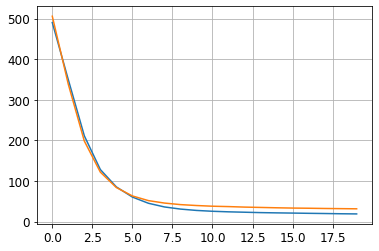

In [57]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.gca()
plt.show()

In [58]:
y_pred

array([[27.602867],
       [34.578102],
       [18.791553]], dtype=float32)